# Inferring Cosmo from PM Simulation

In [1]:
!hostname
!python -c "import jax; print(jax.default_backend(), jax.devices())"
# import jax; print(jax.__file__)
# !nvidia-smi

feynmangpu04.cluster.local


gpu [cuda(id=0)]


In [2]:
import os
os.environ['XLA_PYTHON_CLIENT_MEM_FRACTION']='.33' # NOTE: jax preallocates GPU (default 75%)

import matplotlib.pyplot as plt
import numpy as np
from getdist import plots, MCSamples

import jax
from jax import random, jit, vmap
import jax.numpy as jnp
import jax_cosmo as jc
# import astropy.units as u

import numpyro
# numpyro.set_platform("gpu")
import numpyro.distributions as dist
from numpyro.handlers import seed, condition, trace

# from jax.experimental.ode import odeint
# import haiku as hk

# import diffrax
# from diffrax import diffeqsolve, ODETerm, Dopri5, LeapfrogMidpoint, PIDController, SaveAt

%matplotlib inline
%load_ext autoreload 
%autoreload 2

## Probabilistic Model

In [254]:
from jaxpm.kernels import fftk
fftk(model_kwargs['mesh_size'])[2].shape

(1, 1, 33)

In [278]:
def lagrangian_bias(init_mesh, pos):
  """
  Compute Lagrangian bias expansion weights as in [Modi+2020](http://arxiv.org/abs/1910.07097).
  """
  b1 = numpyro.sample('b1', dist.Normal(1, 0.25))
  b2 = numpyro.sample('b2', dist.Normal(0, 0.25))


  delta_part = cic_read(init_mesh, pos)
  delta_sqr_part = delta_part**2

  weights = 1\
            + b1 * delta_part\
            + b2 * (delta_sqr_part - delta_sqr_part.mean())
  return weights

In [267]:
from jaxpm.painting import cic_read

def lagrangian_bias(init_mesh, pos):
  """
  Compute Lagrangian bias expansion weights as in [Modi+2020](http://arxiv.org/abs/1910.07097).
  """
  b1 = numpyro.sample('b1', dist.Normal(1, 0.25))
  b2 = numpyro.sample('b2', dist.Normal(0, 5))
  bs = numpyro.sample('bs', dist.Normal(0, 5))
  bnl = numpyro.sample('bnl', dist.Normal(0, 5))

  delta_part = cic_read(init_mesh, pos)
  delta_sqr_part = delta_part**2


  delta_k = jnp.fft.rfftn(init_mesh)
  

  
  shear_sqr = jnp.fft.irfftn(field)
  delta_nabla = jnp.fft.irfftn(field)
  shear_sqr_part = cic_read(shear_sqr, pos)
  delta_nabla_part = cic_read(delta_nabla, pos)


  weights = 1\
            + b1 * delta_part\
            + b2 * (delta_sqr_part - delta_sqr_part.mean())\
            + bs * (shear_sqr_part - shear_sqr_part.mean())\
            + bnl * delta_nabla_part
  return weights



def rsd(cosmo, a, p):
  """
  Redshift-Space Distortion (RSD) displacement from cosmology and Particle Mesh (PM) momentum.
  """
  a = jnp.atleast_1d(a)
  # Divide PM momentum by `a` once to retrieve velocity, and once again for comobile velocity  
  dx_rsd = p / (jnp.sqrt(jc.background.Esqr(cosmo, a)) * a**2)
  # Set velocity to 0 except first direction assumed to be the line of sight 
  dx_rsd = dx_rsd.at[:,1:].set(0)
  return dx_rsd


In [268]:
from montecosmo.models import cosmo_prior, linear_pk_interp, linear_field
from jaxpm.pm import lpt
from jaxpm.painting import cic_paint
# from jaxpm.growth import growth_rate

def forward_model(box_size, mesh_size, scale_factor_lpt, scale_factor_obs, galaxy_density, 
                  trace_reparam=True, trace_deterministic=False):
  """
  A forward model, where the relevant variables can be traced.
  """
  # Sample cosmology
  cosmology = cosmo_prior(trace_reparam)

  # Sample initial conditions
  pk_fn = linear_pk_interp(cosmology, n_interp=256)
  init_mesh = linear_field(mesh_size, box_size, pk_fn, trace_reparam)

  # Create regular grid of particles
  x_part = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_size]),axis=-1).reshape([-1,3])

  # Compute Lagrangian bias expansion weights
  lbe_weights = lagrangian_bias(init_mesh, x_part)
  
  # LPT displacement
  cosmology._workspace = {}  # FIXME: this a temporary fix
  dx, p_part, f = lpt(cosmology, init_mesh, x_part, a=scale_factor_lpt)
  # NOTE: lpt supposes given mesh follows linear pk at a=1, and correct by growth factor to get forces at wanted scale factor
  x_part = x_part + dx

  if trace_deterministic: x_part = numpyro.deterministic('lpt_part', x_part)

  # XXX: here N-body displacement
  # x_part, v_part = ... (scale_factor_obs)

  # RSD displacement
  dx_rsd = rsd(cosmology, scale_factor_obs, p_part)
  x_part = x_part + dx_rsd

  if trace_deterministic: x_part = numpyro.deterministic('rsd_part', x_part)

  # CIC paint weighted by Lagrangian bias expansion
  biased_mesh = cic_paint(jnp.zeros(mesh_size), x_part, lbe_weights)

  if trace_deterministic: biased_mesh = numpyro.deterministic('biased_mesh', biased_mesh)

  # Observe
  ## Direct observation
  # obs_mesh = numpyro.sample('obs_mesh', dist.Delta(biased_mesh))
  ## Normal noise 
  # obs_mesh = numpyro.sample('obs_mesh', dist.Normal(biased_mesh, 0.1))
  ## Poisson noise
  gxy_intens_mesh = biased_mesh * (galaxy_density * box_size.prod() / mesh_size.prod())
  obs_mesh = numpyro.sample('obs_mesh', dist.Poisson(gxy_intens_mesh))
  return obs_mesh

In [3]:
from montecosmo.models import cosmo_prior, linear_pk_interp, linear_field
from jaxpm.pm import lpt
from jaxpm.painting import cic_paint


def forward_model(box_size, mesh_size, scale_factor_lpt, scale_factor_obs, galaxy_density, 
                  trace_reparam=True, trace_deterministic=False):
  """
  A forward model, where the relevant variables can be traced.
  """
  # Sample cosmology
  cosmology = cosmo_prior(trace_deterministic)

  # Sample initial conditions
  pk_fn = linear_pk_interp(cosmology, n_interp=256)
  init_mesh = linear_field(mesh_size, box_size, pk_fn)
  if trace_deterministic:
    init_mesh = numpyro.deterministic('init_mesh', init_mesh)

  # Create regular grid of particles
  particles_pos = jnp.stack(jnp.meshgrid(*[jnp.arange(s) for s in mesh_size]),axis=-1).reshape([-1,3])
  
  # Initial displacement with LPT
  cosmology._workspace = {}  # FIXME: this a temporary fix
  dx, p, f = lpt(cosmology, init_mesh, particles_pos, a=scale_factor_lpt)
  # NOTE: lpt supposes given mesh follows linear pk at a=1, and correct by growth factor to get forces at wanted scale factor.
  particles_pos = particles_pos + dx

  # Cloud In Cell painting
  lpt_mesh = cic_paint(jnp.zeros(mesh_size), particles_pos)
  if trace_deterministic:
    lpt_mesh = numpyro.deterministic('lpt_mesh', lpt_mesh)

  # Observe
  ## Direct observation
  # obs_mesh = numpyro.sample('obs_mesh', dist.Delta(lpt_mesh))
  ## Normal noise 
  # obs_mesh = numpyro.sample('obs_mesh', dist.Normal(lpt_mesh, 0.1))
  ## Poisson noise
  gxy_intens_mesh = (lpt_mesh + 1) * (galaxy_density * box_size.prod() / mesh_size.prod())
  obs_mesh = numpyro.sample('obs_mesh', dist.Poisson(gxy_intens_mesh))
  return obs_mesh

In [4]:
# Model params
model_kwargs = {}

## Mesh and box parameters
mesh_length = 32 # 64
box_length = 320 # in Mpc/h (aim for cell lengths between 1 and 10 Mpc/h)
model_kwargs['mesh_size'] = np.array([mesh_length, mesh_length, mesh_length])
model_kwargs['box_size'] = np.array([box_length, box_length, box_length])  # in Mpc/h

## Scale factors
model_kwargs['scale_factor_lpt'] = 0.5
model_kwargs['scale_factor_obs'] = 0.5

## Galaxies
model_kwargs['galaxy_density'] = 1e-3 # in galaxy / (Mpc/h)^3

## Debugging
model_kwargs['trace_reparam'] = True
model_kwargs['trace_deterministic'] = True

cell_lengths=[10.0, 10.0, 10.0] Mpc/h


2023-12-11 15:45:06.719189: W external/xla/xla/service/gpu/nvptx_compiler.cc:679] The NVIDIA driver's CUDA version is 11.5 which is older than the ptxas CUDA version (11.8.89). Because the driver is older than the ptxas version, XLA is disabling parallel compilation, which may slow down compilation. You should update your NVIDIA driver or use the NVIDIA-provided CUDA forward compatibility packages.


k_nyquist=0.31416 h/Mpc, delta_k=0.01963 h/Mpc
mean_galaxy_cell_intensity=1.000 galaxy/cell


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **

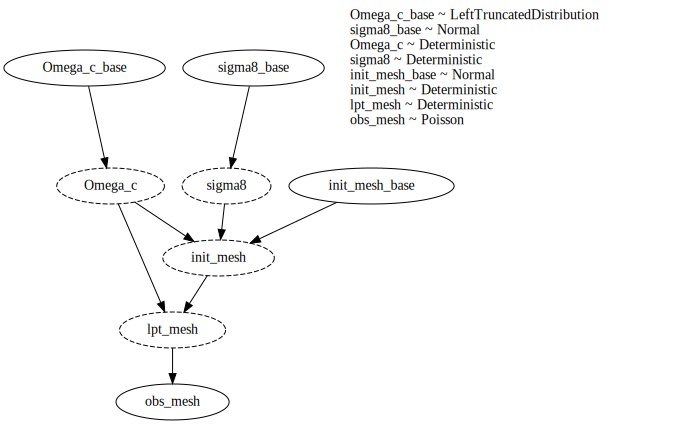

In [5]:
# Print infos
cell_lengths = list( model_kwargs['box_size'] / model_kwargs['mesh_size'] )
print(f"{cell_lengths=} Mpc/h")

k_nyquist = 2 * jnp.pi * jnp.min(model_kwargs['mesh_size'] / model_kwargs['box_size']) / 2
delta_k = 2 * jnp.pi * jnp.min(1 / model_kwargs['box_size']) 
# (2\pi factor because of Fourier transform definition)
print(f"{k_nyquist=:.5f} h/Mpc, {delta_k=:.5f} h/Mpc")

mean_galaxy_cell_intensity = model_kwargs['galaxy_density'] * model_kwargs['box_size'].prod() / model_kwargs['mesh_size'].prod()
print(f"{mean_galaxy_cell_intensity=:.3f} galaxy/cell")

# Render model
numpyro.render_model(model=forward_model, model_kwargs=model_kwargs, render_distributions=True, render_params=True)

## Simulate

In [6]:
# Cosmological parameters
cosmo_var_names = ['Omega_c', 'sigma8']
cosmo_var_labels = [r'\Omega_c', r'\sigma_8']
# TODO: dict name:(mean, var) or (min,max) for cosmo_prior?

# Condition model on some cosmology and sample
fiducial_cosmo_params_base = {var_name+"_base": 0. for var_name in cosmo_var_names}
fiducial_model = condition(forward_model, fiducial_cosmo_params_base) # NOTE: Only condition on random sites, not deterministic ones

# Get trace
fiducial_model_trace = trace(seed(fiducial_model, rng_seed=0)).get_trace(**model_kwargs)
# Check cosmology
fiducial_cosmo_params = {var_name: fiducial_model_trace[var_name]['value'] for var_name in cosmo_var_names}
fiducial_cosmology = jc.Planck15(**fiducial_cosmo_params)
print(f"Fiducial {fiducial_cosmology}")

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


Fiducial Cosmological parameters: 
    h:        0.6774 
    Omega_b:  0.0486 
    Omega_c:  0.25 
    Omega_k:  0.0 
    w0:       -1.0 
    wa:       0.0 
    n:        0.9667 
    sigma8:   0.831


## Power spectra

In [241]:
from jaxpm.utils import power_spectrum
from jaxpm.painting import cic_paint, compensate_cic

# Get meshes from model trace
init_mesh = fiducial_model_trace['init_mesh']['value']
biased_mesh = fiducial_model_trace['biased_mesh']['value']
obs_mesh = fiducial_model_trace['obs_mesh']['value']
# Get other meshes from model trace particles, compensate for CIC painting convolution
zeros_mesh = jnp.zeros(model_kwargs['mesh_size'])
lpt_mesh = cic_paint(zeros_mesh, fiducial_model_trace['lpt_part']['value'])
rsd_mesh = cic_paint(zeros_mesh, fiducial_model_trace['rsd_part']['value'])

# Compute power spectra
pk_lin_init = linear_pk_interp(fiducial_cosmology)
pk_lin_lpt = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_lpt'])
pk_lin_obs = linear_pk_interp(fiducial_cosmology, scale_factor=model_kwargs['scale_factor_obs'])

pk_init = power_spectrum(init_mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])
pk_lpt = power_spectrum(compensate_cic(lpt_mesh), kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])
pk_rsd = power_spectrum(compensate_cic(rsd_mesh), kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])
pk_biased = power_spectrum(compensate_cic(biased_mesh), kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


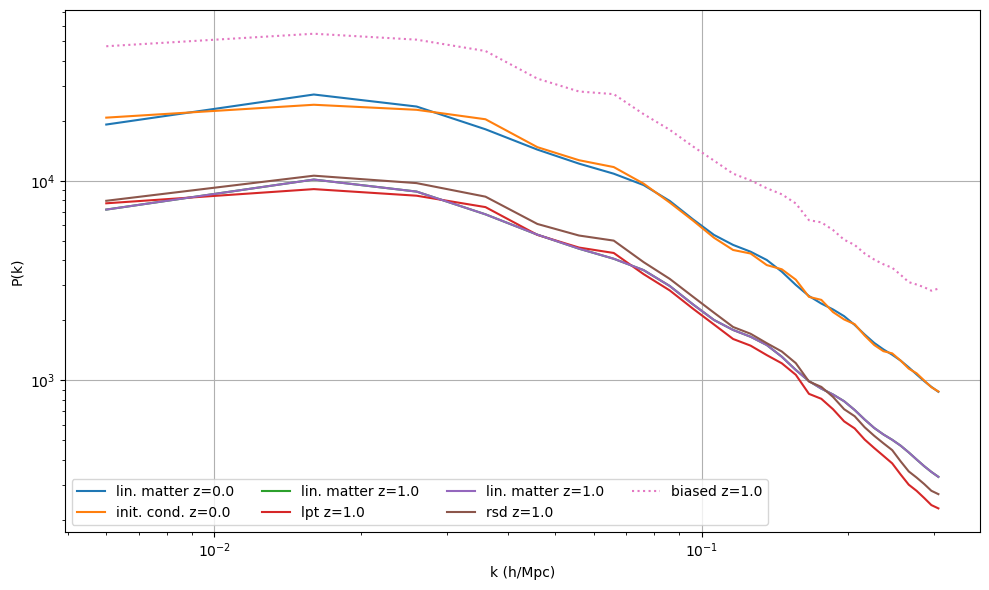

In [242]:
plt.figure(figsize=(10,6))
plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), label=f"lin. matter z={1/1-1}")
plt.loglog(pk_init[0], pk_init[1], label=f"init. cond. z={1/1-1}")
plt.loglog(pk_init[0], pk_lin_lpt(pk_init[0]), label=f"lin. matter z={1/model_kwargs['scale_factor_lpt']-1}")
plt.loglog(pk_lpt[0], pk_lpt[1], label=f"lpt z={1/model_kwargs['scale_factor_lpt']-1}")
plt.loglog(pk_init[0], pk_lin_obs(pk_init[0]), label=f"lin. matter z={1/model_kwargs['scale_factor_obs']-1}")
plt.loglog(pk_rsd[0], pk_rsd[1], label=f"rsd z={1/model_kwargs['scale_factor_obs']-1}")
plt.loglog(pk_biased[0], pk_biased[1], ls=':', label=f"biased z={1/model_kwargs['scale_factor_obs']-1}")
plt.grid(), plt.legend(ncols=4), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)")
plt.tight_layout(), plt.show();

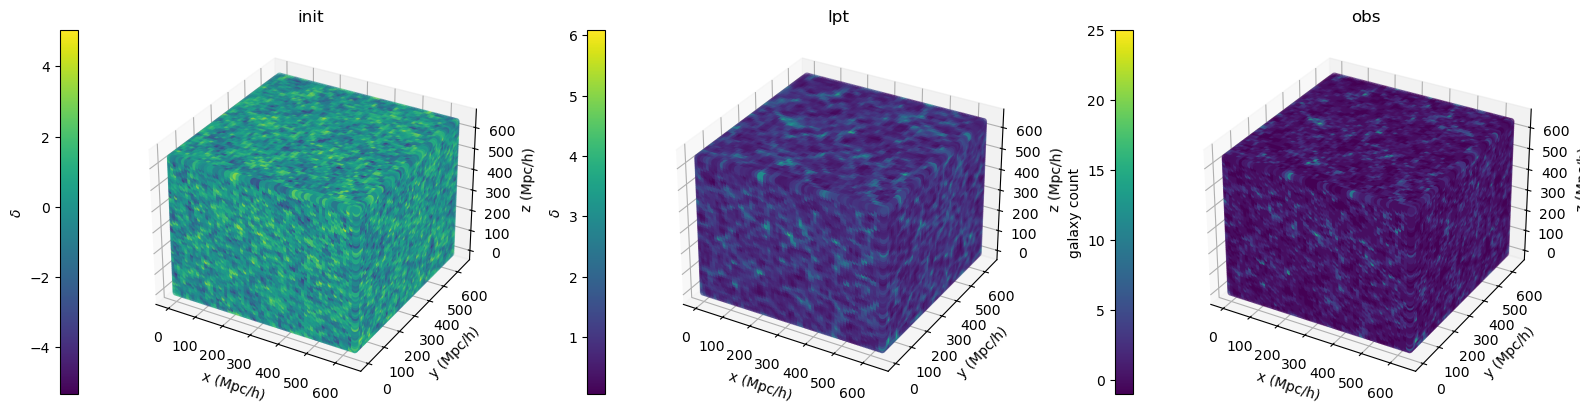

In [243]:
plt.figure(figsize=(16,4))
# # xx, yy, zz = np.indices(cmb_mesh.shape) # to get indices
xx, yy, zz = np.mgrid[[slice(0,box_length,init_mesh.shape[i]*1j) 
                       for i, box_length in enumerate(model_kwargs['box_size'])]] # to get distances
cmap = plt.colormaps['viridis']

ax3D = plt.subplot(131, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=init_mesh.flatten(), cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("init")

ax3D = plt.subplot(132, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=lpt_mesh.flatten(), cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"$\delta$")
plt.title("lpt")

ax3D = plt.subplot(133, projection='3d')
p3d = ax3D.scatter(xx, yy, zz, marker ="o", c=obs_mesh.flatten(), cmap=cmap)
ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)"), ax3D.set_zlabel("z (Mpc/h)")
plt.colorbar(p3d, location='left').set_label(r"galaxy count")
plt.title("obs")
# ax3D.set_box_aspect(None, zoom=0.8)

plt.tight_layout(), plt.show();

## Inference

In [13]:
# Condition model
obs_var_names = ['obs_mesh'] # NOTE: Only condition on random sites
obs_values = {var_name: fiducial_model_trace[var_name]['value'] for var_name in obs_var_names}
observed_model = condition(forward_model, obs_values)  

# Initialize sampler
init_var_names = ['Omega_c_base', 'sigma8_base', 'init_mesh_base'] # NOTE: Only init on random sites
init_values = {var_name: fiducial_model_trace[var_name]['value'] for var_name in init_var_names}

# # Load some inverse mass matrix
# with open(save_path+f"_invM.p", 'rb') as file:
#     variance_as_invM = pickle.load(file)

nuts_kernel = numpyro.infer.NUTS(
    model=observed_model,
    init_strategy=numpyro.infer.init_to_value(values=init_values),
    # inverse_mass_matrix=variance_as_invM, 
    adapt_mass_matrix=False,
    # dense_mass=[('Omega_c_base', 'sigma8_base')], # NOTE: dense matrix for cosmo params joint, diagonal for the rest
    # step_size=0.01, 
    # adapt_step_size=False,
    max_tree_depth=5,)

hmc_kernel = numpyro.infer.HMC(
    model=observed_model,
    init_strategy=numpyro.infer.init_to_value(values=init_values),
    num_steps=2,)

# Propose MALA step size based on Chen+2019 http://arxiv.org/abs/1801.02309
L_smoothness, m_strong_convex = 5, 1 # log density regularity properties
condition_number = L_smoothness / m_strong_convex
print(f"MALA step size proposal={1 / (L_smoothness * (model_kwargs["mesh_size"].prod() * condition_number)**0.5):e}")

from numpyro.contrib.tfp.mcmc import MetropolisAdjustedLangevinAlgorithm
mala_kernel = MetropolisAdjustedLangevinAlgorithm(model=observed_model,
                                                  init_strategy=numpyro.infer.init_to_value(values=init_values),
                                                  step_size=0.1,)

mcmc = numpyro.infer.MCMC(
       sampler=mala_kernel,
       num_warmup=1000,
       num_samples=1000, # for each run
       num_chains=4,
    #    chain_method="vectorized", 
       progress_bar=True,)

MALA step size proposal=4.941059e-04


In [14]:
import pickle
# Variables to save
save_var_names = cosmo_var_names + ['Omega_c_base', 'sigma8_base', 'init_mesh']
# Saves directory
save_directory = os.path.expanduser("~/scratch/npys/") # or in "~/work/npys/"
save_name = "obs_lpt32__4MALA"
save_path = os.path.join(save_directory, save_name)
# save_path = os.path.join(save_directory, save_name, save_name)
# Number of runs
n_runs = 2

In [15]:
from montecosmo.utils import sample_and_save
mcmc_runned = sample_and_save(mcmc, model_kwargs, n_runs, save_path, save_var_names)

run 0/2 (warmup)


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
warmup:   4%|▍         | 39/1000 [01:55<47:22,  2.96s/it] 


KeyboardInterrupt: 

In [ ]:
from montecosmo.utils import sample_and_save
mcmc_runned = sample_and_save(mcmc, model_kwargs, n_runs, save_path, save_var_names)

run 0/2 (warmup)


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)
/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **

run 1/2


sample: 100%|██████████| 1000/1000 [05:00<00:00,  3.33it/s]


run 2/2


sample: 100%|██████████| 1000/1000 [05:05<00:00,  3.28it/s]


## Analysis

In [35]:
from montecosmo.utils import load_runs

print(f"loading: {save_name}")
start_run, end_run = 0, 2
# Load only cosmological samples
cosmo_post_samples = load_runs(cosmo_var_names, save_path, start_run, end_run)
cosmo_post_samples_arr = np.array(list(cosmo_post_samples.values())).T
# Load saved samples
post_samples = load_runs(save_var_names, save_path, start_run, end_run)

loading: obs_lpt32__MALA
total num samples=3000
total num samples=3000


### Chain

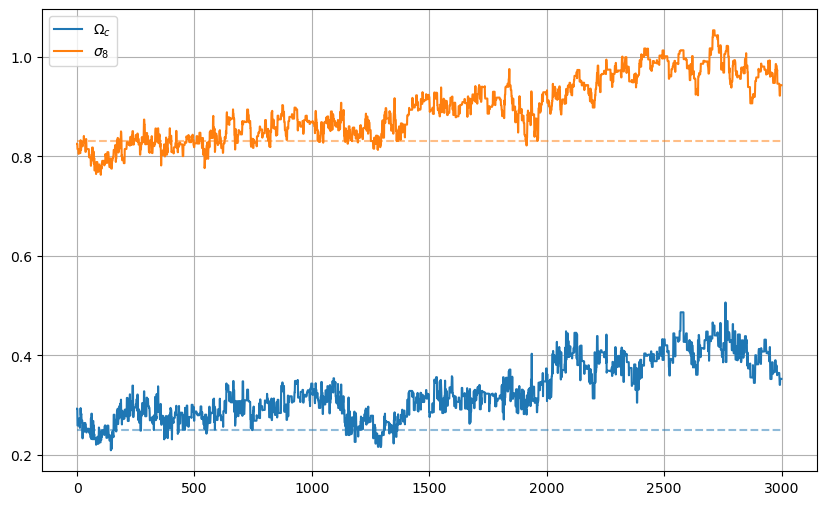

In [36]:
# Plot chain
plt.figure(figsize=(10,6))
plt.plot(cosmo_post_samples_arr, label=["$"+label+"$" for label in cosmo_var_labels])
plt.hlines(fiducial_cosmo_params.values(), 
           xmin=0, xmax=len(cosmo_post_samples_arr), 
           ls="--", alpha=0.5,
           color=["C"+str(i) for i in range(len(cosmo_post_samples_arr))],)
plt.legend(), plt.grid(), 
plt.savefig(save_path+"_chain")
plt.show()

Removed no burn in
Removed no burn in


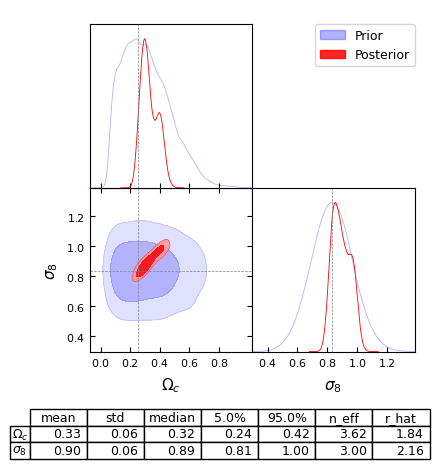

In [37]:
# Diagnostics
# numpyro.diagnostics.print_summary(cosmo_post_samples, group_by_chain=False) # NOTE: group_by_chain if several chains
summary_dic = numpyro.diagnostics.summary(cosmo_post_samples, group_by_chain=False) # NOTE: group_by_chain if several chains
summary_arr = [list(list(summary_dic.values())[i].values()) for i in range(len(summary_dic.values()))]

# Define a custom formatting function to vectorize on summary array
def format_value(value):
    return f"{value:0.2f}"

# Sample from prior
def cosmo_prior_plate(plate_size):
    with numpyro.plate('cosmo_prior_plate', plate_size):
        cosmo_prior(trace_reparam=True)

plate_size = 10000
cosmo_prior_trace = trace(seed(cosmo_prior_plate, 0)).get_trace(plate_size)
cosmo_prior_samples_arr = np.array([cosmo_prior_trace[key]['value'] for key in cosmo_var_names]).T

# Triangle plot
post_samples_gd = MCSamples(samples=cosmo_post_samples_arr, names=cosmo_var_names, labels=cosmo_var_labels)
prior_samples_gd = MCSamples(samples=cosmo_prior_samples_arr, names=cosmo_var_names, labels=cosmo_var_labels)
gd = plots.get_subplot_plotter(subplot_size=None)
# gd.settings.solid_colors='tab10_r'
gd.triangle_plot(roots=[prior_samples_gd, post_samples_gd],
                 markers=fiducial_cosmo_params,
                 filled=True, 
                 legend_labels=["Prior", "Posterior"],
                 line_args=[{'color':'b', 'alpha':0.3},{'color':'r'}],
                 contour_args=[{'color':'b', 'alpha':0.3},{'color':'r'}],)

# Plot summary table
plt.subplot(position=[0,0,1,1]), plt.axis('off')
# gd.fig.axes[-1]('tight'), plt.axis('tight'), plt.subplots_adjust(top=2), plt.gcf().patch.set_visible(False), 
plt.table(cellText=np.vectorize(format_value)(summary_arr),
            # rowLabels=list(summary_dic.keys()),
            rowLabels=["$"+label+"$" for label in cosmo_var_labels], 
            colLabels=list(list(summary_dic.values())[0].keys()),)
plt.savefig(save_path+"_triangle", bbox_inches='tight') # NOTE: tight bbox required to save table
plt.show();

### Mass matrix

In [152]:
# Load mass matrix
with open(save_path+f"_laststate.p", 'rb') as file:
    last_state = pickle.load(file)
    
inverse_mass_matrix = last_state.adapt_state.inverse_mass_matrix
print(inverse_mass_matrix)
# np.cov(np.array([post_samples[var_name] for var_name in ['Omega_c_base', 'sigma8_base']]))

{('Omega_c_base', 'sigma8_base'): Array([1., 1.], dtype=float32)}


In [ ]:
# Plot inverse mass matrix vs. posterior sample variance
invM_arr = np.array(list(inverse_mass_matrix.values()))[0] # also jax.tree_util.tree_flatten(inverse_mass_matrix)[0][0]
var_names = list(inverse_mass_matrix.keys())[0]

post_variance_mesh, post_variance_cosmo = [], []
invM_mesh, invM_cosmo, invM_cosmo_name = [], [], []
invM_head = 0
for var_name in var_names:
    var_variance = post_samples[var_name].var(axis=0).flatten()
    new_invM_head = invM_head + len(var_variance)
    if var_name in ['init_mesh_base']:
        post_variance_mesh = np.concatenate((post_variance_mesh, var_variance))
        invM_mesh = np.concatenate((invM_mesh, invM_arr[invM_head: new_invM_head]))
    else:
        post_variance_cosmo = np.concatenate((post_variance_cosmo, var_variance))
        invM_cosmo = np.concatenate((invM_cosmo, invM_arr[invM_head: new_invM_head]))
        invM_cosmo_name += [var_name]
    invM_head = new_invM_head


plt.figure(figsize=(14,4))
plt.subplot(1,5,(1,2))
x_pos = np.arange(len(invM_cosmo))
plt.bar(x_pos, invM_cosmo, width=.5, label="inverse mass")
plt.bar(x_pos+.4, post_variance_cosmo, width=.5, label="sample var")
plt.xticks(x_pos+.2, invM_cosmo_name)
plt.legend(), plt.grid()

plt.subplot(1,5,(3,5))
# argsort_invM_mesh = np.argsort(invM_mesh) 
# plt.plot(invM_mesh[argsort_invM_mesh][::-1], label="inverse mass")
# plt.plot(post_variance_mesh[argsort_invM_mesh][::-1], label="sample var")
argsort_postvar_mesh = np.argsort(post_variance_mesh) 
plt.plot(invM_mesh[argsort_postvar_mesh][::-1], label="inverse mass")
plt.plot(post_variance_mesh[argsort_postvar_mesh][::-1], label="sample var")
plt.xlabel("init_mesh_base")
plt.legend(), plt.tight_layout(), plt.grid()
plt.savefig(save_path+"_invMvar");

In [ ]:
# Save posterior variance as inverse mass matrix format
post_variance = []
for var_name in var_names:
    if var_name == 'init_mesh_base':
        var_name = 'init_mesh'
        post_variance = np.concatenate((post_variance, np.ones(post_samples[var_name][0].flatten().shape)))
    else:
        post_variance = np.concatenate((post_variance, post_samples[var_name].var(axis=0).flatten()))
        post_variance = np.concatenate((post_variance, ))
variance_as_invM = {var_names: post_variance}
print(variance_as_invM)

# with open(save_path+f"_invM.p", 'wb') as file:
#     pickle.dump(post_variance, file, protocol=pickle.HIGHEST_PROTOCOL)

### Init. cond. 

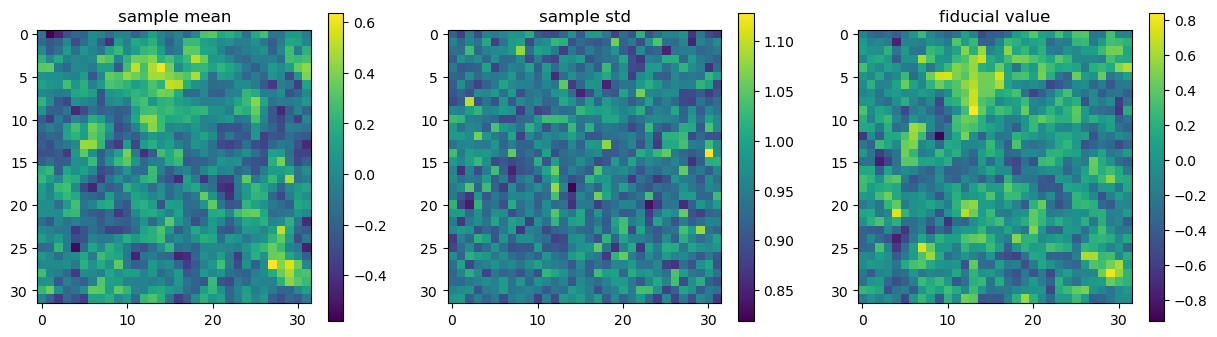

In [42]:
plt.figure(figsize=(15,4))
plt.subplot(131)
plt.imshow(post_samples['init_mesh'].mean(0).mean(0))
plt.title("sample mean"), plt.colorbar()
plt.subplot(132)
plt.imshow(post_samples['init_mesh'].std(0).mean(0))
plt.title("sample std"), plt.colorbar()
plt.subplot(133)
plt.imshow(fiducial_model_trace['init_mesh']['value'].mean(0))
plt.title("fiducial value"), plt.colorbar()
plt.show();

### Spectrum distribution

In [33]:
n_pks = 1000
pks = np.empty((n_pks, *pk_init[1].shape))
for i_sample in range(n_pks):
    mesh = post_samples['init_mesh'][-i_sample]
    _, pks[i_sample] = power_spectrum(mesh, kmin=0.001, dk=0.01, boxsize=model_kwargs['box_size'])

pk_023, pk_159, pk_500, pk_841, pk_977 = np.quantile(pks, q=[0.023, 0.159, 0.5, 0.841, 0.977], axis=0)

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/lax/lax.py:513: ComplexWarning: Casting complex values to real discards the imaginary part
  return _convert_element_type(operand, new_dtype, weak_type=False)


/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


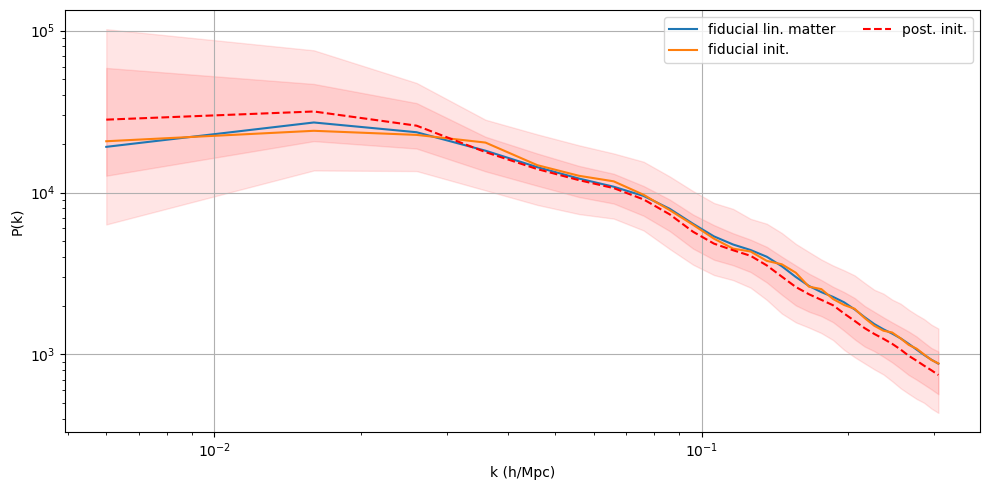

In [34]:
plt.figure(figsize=(10,5))
plt.subplot(111)
plt.loglog(pk_init[0], pk_lin_init(pk_init[0]), label=f"fiducial lin. matter")
plt.loglog(pk_init[0], pk_init[1], label=f"fiducial init.")
plt.loglog(pk_init[0], pk_500, color='red', ls='--', label=f"post. init.")
plt.fill_between(pk_init[0], pk_159, pk_841, alpha=0.1, color='red')
plt.fill_between(pk_init[0], pk_023, pk_977, alpha=0.1, color='red')
plt.legend(ncols=2), plt.xlabel("k (h/Mpc)"), plt.ylabel("P(k)")
plt.grid(), plt.tight_layout()
plt.savefig(save_path+"_Pkdist");

### Joint density

In [100]:
from numpyro.infer.util import log_density

box_corner = 2
box = np.array([[-1, box_corner], [-box_corner, box_corner]])
xx, yy = np.mgrid[[slice(box_ax[0],box_ax[1],30*1j) 
                       for box_ax in box]] # to get distances

log_density_fn = lambda xx_ij, yy_ij, to_marg: log_density(
                            model=forward_model, 
                            model_args=(), 
                            model_kwargs=model_kwargs, 
                            params={'Omega_c_base':xx_ij, 
                                    'sigma8_base':yy_ij, 
                                    'init_mesh_base':to_marg,
                                    'obs_mesh':obs_values['obs_mesh'],},)[0]
log_density_jit = jit(vmap(vmap(vmap(log_density_fn, in_axes=(0,0,None)), in_axes=(0,0,None)), in_axes=(None, None, 0)))

# zz = jnp.array([[log_density(forward_model, (), model_kwargs,
#                               {'Omega_c_base':xx_ij, 'sigma8_base':yy_ij, 'init_mesh_base':init_values['init_mesh_base'],'obs_mesh':obs_values['obs_mesh'],})[0] 
#                               for xx_ij, yy_ij in zip(xx_i, yy_i)] for xx_i, yy_i in zip(xx, yy)]) # unefficient implementation

logp_meshes = log_density_jit(xx, yy, jnp.array([init_values['init_mesh_base']]))
for i in range(3):
    sample_shape = (4, *model_kwargs['mesh_size'])
    fields = dist.Normal(jnp.zeros(sample_shape), jnp.ones(sample_shape)/2).sample(random.PRNGKey(0))
    fields = fields + init_values['init_mesh_base']
    logp_meshes = np.concatenate((logp_meshes, log_density_jit(xx, yy, fields)))
np.save(save_path+"_logp", logp_meshes)
print(logp_meshes.shape)

/feynman/work/dphp/hs276503/miniforge3/envs/montecosmoenv/lib/python3.12/site-packages/jax/_src/numpy/array_methods.py:733: UserWarning: Explicitly requested dtype <class 'jax.numpy.int64'> requested in astype is not available, and will be truncated to dtype int32. To enable more dtypes, set the jax_enable_x64 configuration option or the JAX_ENABLE_X64 shell environment variable. See https://github.com/google/jax#current-gotchas for more.
  return getattr(self.aval, name).fun(self, *args, **kwargs)


ValueError: setting an array element with a sequence. The requested array has an inhomogeneous shape after 1 dimensions. The detected shape was (4,) + inhomogeneous part.

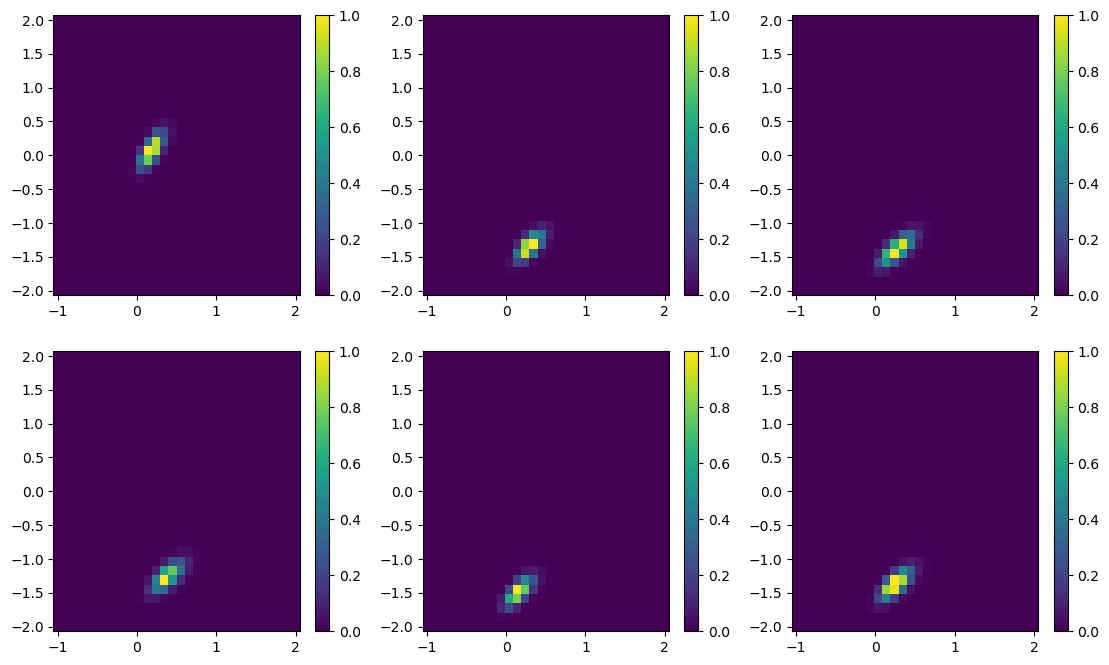

In [92]:
n_subplots = len(logp_meshes)
n_rows = 2
n_cols = int(np.ceil(n_subplots/n_rows))
plt.figure(figsize=(n_cols*4.5, n_rows*4))
for i_subplot in range(n_subplots):
    ax3D = plt.subplot(n_rows, int(np.ceil(n_subplots/n_rows)), i_subplot+1)
    # p3d = ax3D.pcolormesh(xx, yy, zz, cmap='viridis')
    p_mesh = jnp.exp(logp_meshes[i_subplot] - jnp.max(logp_meshes[i_subplot]))
    plt.pcolormesh(xx, yy, p_mesh, cmap='viridis')
    # plt.pcolormesh(xx, yy, logp_meshes[i_subplot], cmap='viridis')
    # p3d = ax3D.pcolormesh(xx, yy, p_mesh, cmap='viridis')
    # ax3D.set_xlabel("x (Mpc/h)"), ax3D.set_ylabel("y (Mpc/h)")
    plt.colorbar()
plt.savefig(save_path+"_postslice")
plt.show();

# Tail